In [1]:
import scipy.constants as cst
import numpy as np
import matplotlib.pyplot as plt
import Functions
import pandas as pd 
import isa
from scipy.signal import find_peaks
from copy import deepcopy 
CO2 = Functions.gas('./Absorbtion Continua up to 5000cm^-1/CO2.csv',44,415.16 )
CH4 = Functions.gas('./Absorbtion Continua up to 5000cm^-1/CH4.csv',44,415.16)
H2O = Functions.gas('./Absorbtion Continua up to 5000cm^-1/H2O.csv',44,25000 )

Absorption Peaks, correspond to excitation of molecules vibrational and rotational modes, which are quantised, this gives them a discrete nature. This discrete nature is approximate when the molecule is in a sea of other molecules, the constant collisions change energy eigenvalues of the transition due to collision times being smaller than the emission processes, the shortened characteristic time gives higher energy uncertainty, and is well described by a lorentzian function withe HWHM(Half Width Half Max) = $ \gamma_{air} $. In addition, self broadening of the emission occurs due to shorter lived excited states having higher uncertainty on the energy of the decay,which is also of a lorentzian, HWHM = $ \gamma_{self} $.  
$$ \gamma(p,T) = (\frac{T_{ref}}{T})^{n_{air}}(\gamma_{air}(p_{ref},T_{ref})(p-p_{self})+\gamma_{self}(p_{ref},T_{ref})p_{self})$$
The pressure and temperature dependant HWHM $\gamma$, is also dependant on $p_{self}$ which is the partial pressure of the gas in question. The data was from the HITRAN Database, and $p_{ref},T_{ref} = 1atm,\space 296k$.  
The lorentzian profile modelled: 
$$ f(\gamma,\nu,\nu_0) = \frac{1}{\pi}\frac{\gamma}{\gamma^2 +(\nu- \nu_0)^2}$$
Aside, doppler shifts can also be added, however, they have not been implemented.

<ipython-input-2-a50a1f74cade>:8: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot([5,x[intersect]],[hm,hm],Label = 'Half Width Half Max:$\gamma$',linestyle ='--',c = 'black')


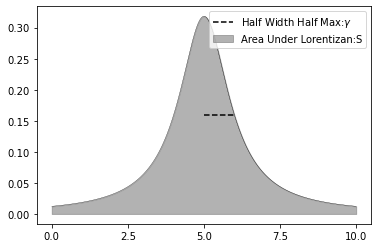

In [2]:
fig, ax =  plt.subplots()
x = np.linspace(0,10,100000)
y = Functions.lorenzian(x,5,1)
ax.plot(x,y,c = 'black', linewidth = 0.3)
ax.fill_between(x,0,y,color ='grey',alpha = 0.6,label = 'Area Under Lorentizan:S')
hm = np.max(y)/2
intersect = np.where(y > hm)[0][-1]
ax.plot([5,x[intersect]],[hm,hm],Label = 'Half Width Half Max:$\gamma$',linestyle ='--',c = 'black')
#plt.plot([5,5],[0,np.max(y)],c = 'black',linestyle ='-.',label ='Maximum')
ax.set_xticks(np.linspace(0,10,5))
plt.legend()
fig.savefig('./Figures/Lorentzian')


Above is the profile of the Lorentzian

In [3]:
##Code Showing fine resolution Lorenzian Broadening
start, stop = 140,180
###To increase the resolution a gas is defined with a much finer nu interval
coarse_coef = np.array(CO2.absorbtion_coeff)[start:stop]
coarse_nu = np.array(CO2.nu)[start:stop]
coarse_gamma_self = np.array(CO2.gamma_self)[start:stop]
coarse_gamma_air = np.array(CO2.gamma_air)[start:stop]
coarse_nair = np.array(CO2.n_air)[start:stop]

#find the absorbtion_peak for the CO2 in the range start stop
absorbtion_peaks, _ = find_peaks(coarse_coef)

##I make a newn gas object with nu values and a much higher resolution
CO2_prime = deepcopy(CO2)


nu = np.linspace(305,319,10000)
peaks = nair = np.zeros_like(nu)
gamma_self = np.zeros_like(nu)
gamma_air = np.zeros_like(nu)
coef = np.zeros_like(nu)

# What are the values of gamma,absorbtion_coeff,etc at the peak
coarse_peak_height = coarse_coef[absorbtion_peaks]
coarse_nu_peaks  = coarse_nu[absorbtion_peaks]
coarse_gamma_self_peaks = coarse_gamma_self[absorbtion_peaks]
coarse_gamma_air_peaks = coarse_gamma_air[absorbtion_peaks]
coarse_nair_peaks =coarse_nair[absorbtion_peaks]
#assign only the peak values of gamma,absorbtion_coeff,etc.They are placed in the array at the closest match of nu ie min(nu[peak]-nu_coarse[peak]) 
for i in range(len(coarse_nu_peaks)):
    ind = np.array(np.where(nu > coarse_nu_peaks[i])[0])[0]
    coef[ind] = coarse_peak_height[i]
    gamma_air[ind] = coarse_gamma_air_peaks[i]
    gamma_self[ind] = coarse_gamma_self_peaks[i]
    nair[ind] = coarse_nair_peaks[i]
#The arrays with only values at the peaks are then assigned as gas.parameter
CO2_prime.absorbtion_coeff  = coef
CO2_prime.gamma_self = (gamma_self)
CO2_prime.gamma_air = (gamma_air)
CO2_prime.n_air = (nair)
CO2_prime.nu = nu


Monochromatic Absorbtion Coefficent ,$k$ ($cm^{-1}/molecule\cdot cm^{-2}$) : 
$$ k(\nu,T,p) = S(\nu)\cdot f(\gamma,\nu,\nu_0)$$
Where S ($cm^{-1}/molecule\cdot cm^{-2}$) is the Spectral Line Intesity and $f$ is the lorentzian.

<ipython-input-4-b62b8a0874f7>:8: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(no_broad_nu[index],no_broad_coef[index],Label = 'Spectral Line Intesity(SW)',linestyle = '',marker = 'x', c = 'purple')


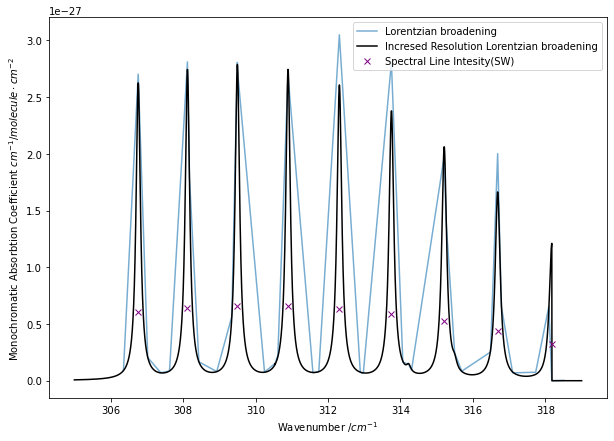

In [4]:

index = [0, 1, 2, 4, 5, 6, 8, 10, 11] #this removes the small peaks which can be seen but added clutter 
no_broad_nu = np.array(CO2.nu[start:stop].iloc[absorbtion_peaks])
no_broad_coef = (coarse_coef[absorbtion_peaks])

plt.figure(figsize=(10,7))
plt.plot(CO2.nu[start:stop],Functions.lorentzain_fit(CO2,0,threshold= 0, start= start,stop= stop),label = 'Lorentzian broadening',alpha = 0.6)
plt.plot(CO2_prime.nu,Functions.lorentzain_fit(CO2_prime,0,threshold= 0,Quantile = False,Dataframe= False ),label = 'Incresed Resolution Lorentzian broadening',c = 'black')
plt.plot(no_broad_nu[index],no_broad_coef[index],Label = 'Spectral Line Intesity(SW)',linestyle = '',marker = 'x', c = 'purple')
plt.xlabel('Wavenumber $/cm^{-1}$')
plt.ylabel(r'Monochromatic Absorbtion Coefficient $cm^{-1}/molecule\cdot cm^{-2}$')
plt.legend()
plt.savefig('./Figures/High_Resolution_Broadening')
